## 6.7960 Final Project - Notebook 3.2
We want to figure out why simply switching from synthetic signal to real signal makes it hard for the model to learn.

- Based on observations, the transformer capturing the shape of the signals, and mistaking all the single peaks in heart beats as noise peaks.

In [31]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from typing import Tuple, Union, Optional, List
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns

### Dataset Construction

In [8]:
peak_amplitude=2
signal_length=10000
chunk_size=50
max_peaks = 3
max_breaks = 3
min_break_length = 200
max_break_length = 1000
peak_width=30

file_path = '/content/100.csv'  # Update this path if necessary
signal_data = pd.read_csv(file_path).squeeze()
mlii_signal = signal_data["'MLII'"].values  # Convert to a NumPy array

def generate_signal(length=1000, peak_amplitude=2, peak_width=30, noise_level=0.1, random_peak_amplitude=400, random_peak_width=200, base_signal=mlii_signal):
    """
    Generate a regular heartbeat signal with random peaks and breaks, and return the positions of anomalies.
    Args:
        length (int): Total length of the signal.
        peak_amplitude (float): Amplitude of the peaks.
        peak_width (int): Width of each peak.
        noise_level (float): Standard deviation of Gaussian noise added to the signal.
    Returns:
        np.ndarray: Generated signal with peaks and breaks.
        list: List of tuples indicating the start and end positions of anomalies (peaks and breaks).
    """
    # Generate a regular triangular heartbeat signal
    t = np.arange(length)
    signal = peak_amplitude * np.abs(np.sin(2 * np.pi * t / peak_width))  # Triangular wave

    # Add noise
    noise = np.random.normal(0, noise_level, length)
    signal += noise

    # use real signal
    start_index = np.random.randint(0, len(base_signal) - length)
    end_index = start_index + length
    signal = base_signal[start_index:end_index].copy().astype(float)

    # mean of the signal
    mean = np.mean(signal)

    # Introduce random breaks
    num_breaks = np.random.randint(1, max_breaks)  # Random number of breaks
    anomalies = []

    for _ in range(num_breaks):
        break_start = np.random.randint(0, length - 200)  # Random starting point
        break_length = np.random.randint(min_break_length, max_break_length)  # Random break length
        break_end = min(length, break_start + break_length)
        signal[break_start:break_end] = mean  # Flatline during the break
        anomalies.append((break_start, break_end))

    # Introduce random peaks
    num_peaks = np.random.randint(1, max_peaks)  # Random number of peaks
    for _ in range(num_peaks):
        peak_center = np.random.randint(random_peak_width, length - random_peak_width)
        peak_start = max(0, peak_center - random_peak_width // 2)
        peak_end = min(length, peak_center + random_peak_width // 2)
        peak = np.exp(-0.5 * ((np.arange(peak_start, peak_end) - peak_center) / (random_peak_width // 6)) ** 2)
        signal[peak_start:peak_end] += random_peak_amplitude * peak
        anomalies.append((peak_start, peak_end))

    return signal, anomalies


def chunk_signal(signal, chunk_size=20):
    """
    Split a signal into chunks.
    Args:
        signal (np.ndarray): The input signal.
        chunk_size (int): Size of each chunk.
    Returns:
        list of np.ndarray: Chunks of the signal.
    """
    return [signal[i:i+chunk_size] for i in range(0, len(signal) - chunk_size + 1, chunk_size)]

def label_chunks(chunks, anomaly_positions, chunk_size=50):
    """
    Label chunks as normal or abnormal based on the positions of anomalies.
    Args:
        chunks (list of np.ndarray): List of signal chunks.
        chunk_size (int): Size of each chunk.
        anomaly_positions (list): List of tuples indicating the start and end positions of anomalies.
    Returns:
        list: Labels for each chunk (0 for normal, 1 for abnormal).
    """
    labels = []
    for i, chunk in enumerate(chunks):
        chunk_start = i * chunk_size
        chunk_end = chunk_start + chunk_size

        # Check if the chunk overlaps with any anomaly (peak or break)
        is_abnormal = any(
            (chunk_start < end and chunk_end > start)  # Overlap condition
            for start, end in anomaly_positions
        )
        labels.append(1 if is_abnormal else 0)  # 1 for abnormal, 0 for normal

    return labels


def construct_dataset(num_signals=100, signal_length=1000, chunk_size=50, peak_amplitude=2.0):
    """
    Construct a dataset of chunked and labeled signals.
    Args:
        num_signals (int): Number of signals to generate.
        signal_length (int): Length of each signal.
        chunk_size (int): Size of each chunk.
        peak_amplitude (float): Amplitude of the heartbeat.
    Returns:
        pd.DataFrame: Dataset with chunks and labels.
    """
    data = []
    for _ in range(num_signals):
        signal, break_positions = generate_signal(length=signal_length, peak_amplitude=peak_amplitude, peak_width=peak_width)
        chunks = chunk_signal(signal, chunk_size=chunk_size)
        labels = label_chunks(chunks, break_positions, chunk_size=chunk_size)
        for chunk, label in zip(chunks, labels):
            data.append({'chunk': chunk, 'label': label})
    return pd.DataFrame(data)

In [9]:
# Generate the dataset
dataset = construct_dataset(num_signals=200, signal_length=signal_length, chunk_size=chunk_size, peak_amplitude=peak_amplitude)

# Preview the dataset
print(dataset.head())

                                               chunk  label
0  [958.0, 961.0, 962.0, 962.0, 969.0, 970.0, 971...      0
1  [954.0, 950.0, 951.0, 952.0, 953.0, 952.0, 951...      0
2  [949.0, 950.0, 948.0, 948.0, 947.0, 946.0, 947...      0
3  [943.0, 942.0, 943.0, 943.0, 943.0, 948.0, 947...      0
4  [950.0, 949.0, 953.0, 957.0, 961.0, 960.0, 960...      0


In [10]:
dataset

,chunk,label
0,"[958.0, 961.0, 962.0, 962.0, 969.0, 970.0, 971...",0
1,"[954.0, 950.0, 951.0, 952.0, 953.0, 952.0, 951...",0
2,"[949.0, 950.0, 948.0, 948.0, 947.0, 946.0, 947...",0
3,"[943.0, 942.0, 943.0, 943.0, 943.0, 948.0, 947...",0
4,"[950.0, 949.0, 953.0, 957.0, 961.0, 960.0, 960...",0
...,...,...
39995,"[964.0, 966.0, 966.0, 964.0, 966.0, 968.0, 967...",0
39996,"[942.0, 940.0, 941.0, 941.0, 939.0, 932.0, 924...",0
39997,"[933.0, 932.0, 936.0, 936.0, 933.0, 931.0, 931...",0
39998,"[937.0, 937.0, 935.0, 932.0, 933.0, 935.0, 937...",0


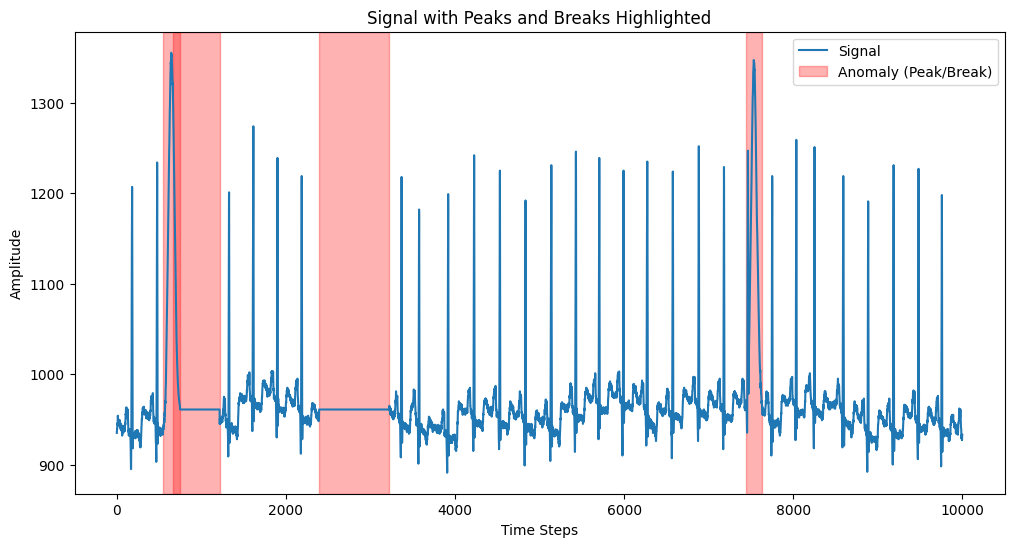

In [11]:
# Generate a test signal with peaks and breaks
example_signal, example_anomalies = generate_signal(length=signal_length, peak_amplitude=peak_amplitude, peak_width=peak_width, noise_level=0.1)

# Chunk and label the signal
chunks = chunk_signal(example_signal, chunk_size=chunk_size)
labels = label_chunks(chunks, example_anomalies, chunk_size=chunk_size)

# Plot the signal
plt.figure(figsize=(12, 6))
plt.plot(example_signal, label='Signal')

# Highlight anomalies (peaks and breaks)
for start, end in example_anomalies:
    plt.axvspan(start, end, color='red', alpha=0.3, label='Anomaly (Peak/Break)' if start == example_anomalies[0][0] else "")

plt.title('Signal with Peaks and Breaks Highlighted')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [12]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, chunk_size, sequence_length):
        """
        Args:
            data (pd.DataFrame): DataFrame with 'chunk' (np.ndarray) and 'label' (int).
            chunk_size (int): Size of each chunk.
            sequence_length (int): Number of chunks per sequence.
        """
        self.chunks = np.stack(data['chunk'].values)  # Convert chunks to 2D array
        self.labels = data['label'].values
        self.chunk_size = chunk_size
        self.sequence_length = sequence_length

        # Normalize chunks
        #self.scaler = StandardScaler()
        #self.chunks = self.scaler.fit_transform(self.chunks.reshape(-1, chunk_size)).reshape(self.chunks.shape)

    def __len__(self):
      return len(self.chunks) // self.sequence_length

    def __getitem__(self, idx):
      start_idx = idx * self.sequence_length
      end_idx = start_idx + self.sequence_length
      sequence = self.chunks[start_idx:end_idx]
      labels = self.labels[start_idx:end_idx]
      return torch.tensor(sequence, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)

# Prepare dataset
sequence_length = signal_length//chunk_size  # Number of chunks in each sequence
batch_size = 32       # Batch size for training

dataset_torch = TimeSeriesDataset(dataset, chunk_size, sequence_length)

# DataLoader
train_dataloader = DataLoader(dataset_torch, batch_size=batch_size, shuffle=True)

In [13]:
dataset_val = construct_dataset(num_signals=20, signal_length=signal_length, chunk_size=chunk_size, peak_amplitude=peak_amplitude)
dataset_val_torch = TimeSeriesDataset(dataset_val, chunk_size, sequence_length)
val_dataloader = DataLoader(dataset_val_torch, batch_size=batch_size, shuffle=True)

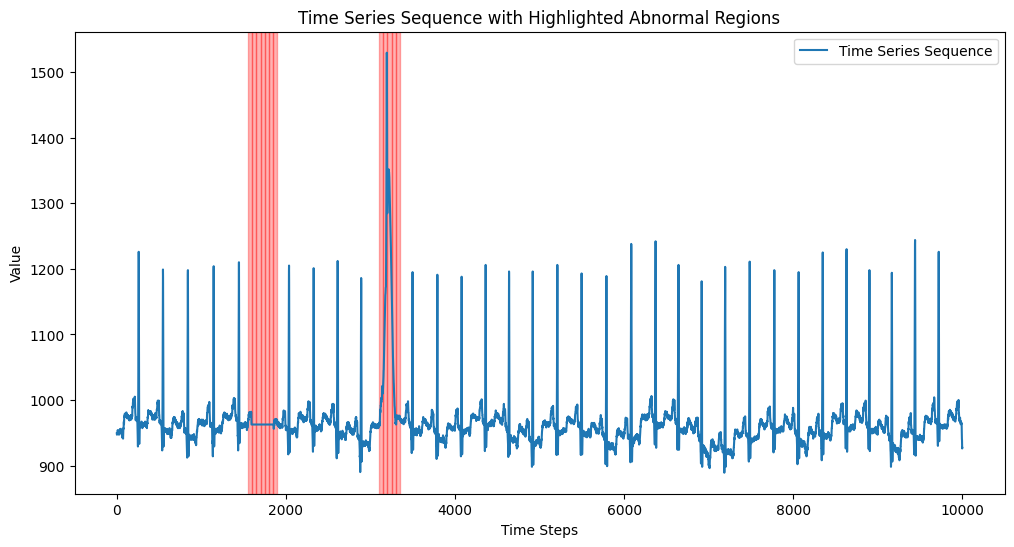

In [14]:
# plot dataset_torch[0] and highlight the abnormal regions labeled by dataset_torch[1]
# Extract the first sequence and its labels
sequence, labels = dataset_val_torch[10]

# Flatten the sequence for plotting
flat_sequence = sequence.numpy().flatten()

# Compute start and end indices for each chunk in the flattened sequence
chunk_starts = np.arange(0, len(flat_sequence), chunk_size)

# Plot the sequence
plt.figure(figsize=(12, 6))
plt.plot(flat_sequence, label="Time Series Sequence")

# Highlight Abnormal Chunks
for i, label in enumerate(labels):
    if label == 1:  # Abnormal chunk
        start = i * chunk_size
        end = start + chunk_size
        plt.axvspan(start, end, color='red', alpha=0.3)

plt.title("Time Series Sequence with Highlighted Abnormal Regions")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.show()

In [15]:
sequence_length

200

### Transformer Model
We start with a Transformer model

#### Implementation of the Transformer

In [35]:
# a utility for calculating running average
class AverageMeter():
    def __init__(self):
        self.num = 0
        self.tot = 0

    def update(self, val: float, sz: float):
        self.num += val*sz
        self.tot += sz

    def calculate(self) -> float:
        return self.num/self.tot

In [36]:
class AttentionHead(nn.Module):
    def __init__(self, dim: int, n_hidden: int):
        # dim: the dimension of the input
        # n_hidden: the dimension of the keys, queries, and values

        super().__init__()

        self.W_K = nn.Linear(dim, n_hidden) # W_K weight matrix
        self.W_Q = nn.Linear(dim, n_hidden) # W_Q weight matrix
        self.W_V = nn.Linear(dim, n_hidden) # W_V weight matrix
        self.n_hidden = n_hidden

    def forward(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. If None, ignore. If not None, then mask[b, i, j]
        #                  contains 1 if (in batch b) token i should attend on token j and 0
        #                  otherwise. shape: (B x T x T)
        #
        # Outputs:
        # attn_output      the output of performing self-attention on x. shape: (Batch x Num_tokens x n_hidden)
        # alpha            the attention weights (after softmax). shape: (B x T x T)
        #

        out, alpha = None, None
        # TODO: Compute self attention on x.
        #       (1) First project x to the query Q, key K, value V.
        #       (2) Then compute the attention weights alpha as:
        #                  alpha = softmax(QK^T/sqrt(n_hidden))
        #           Make sure to take into account attn_mask such that token i does not attend on token
        #           j if attn_mask[b, i, j] == 0. (Hint, in such a case, what value should you set the weight
        #           to before the softmax so that after the softmax the value is 0?)
        #       (3) The output is a linear combination of the values (weighted by the alphas):
        #                  out = alpha V
        #       (4) return the output and the alpha after the softmax

        # ======= Answer START ========
        Q = self.W_Q(x)
        K = self.W_K(x)
        V = self.W_V(x)

        S = torch.matmul(Q, K.transpose(1, 2)) / np.sqrt(self.n_hidden)
        if attn_mask is not None:
          attn_mask = attn_mask.to(S.device)
          S = S.masked_fill(attn_mask == 0, float('-inf'))  # this corresponds to a softmax 0 output

        alpha = torch.softmax(S, dim=2)
        attn_output = torch.matmul(alpha, V)
        # ======= Answer  END ========

        return attn_output, alpha

In [37]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, dim: int, n_hidden: int, num_heads: int):
        # dim: the dimension of the input
        # n_hidden: the hidden dimenstion for the attention layer
        # num_heads: the number of attention heads
        super().__init__()

        # TODO: set up your parameters for multi-head attention. You should initialize
        #       num_heads attention heads (see nn.ModuleList) as well as a linear layer
        #       that projects the concatenated outputs of each head into dim
        #       (what size should this linear layer be?)

        # ======= Answer START ========
        self.heads = nn.ModuleList([AttentionHead(dim, n_hidden) for _ in range(num_heads)])
        self.linear = nn.Linear(num_heads * n_hidden, dim)
        # ======= Answer  END ========

    def forward(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. If None, ignore. If not None, then mask[b, i, j]
        #                  contains 1 if (in batch b) token i should attend on token j and 0
        #                  otherwise. shape: (B x T x T)
        #
        # Outputs:
        # attn_output      the output of performing multi-headed self-attention on x.
        #                  shape: (B x T x dim)
        # attn_alphas      the attention weights of each of the attention heads.
        #                  shape: (B x Num_heads x T x T)

        attn_output, attn_alphas = None, None

        # TODO: Compute multi-headed attention. Loop through each of your attention heads
        #       and collect the outputs. Concatenate them together along the hidden dimension,
        #       and then project them back into the output dimension (dim). Return both
        #       the final attention outputs as well as the alphas from each head.

        # ======= Answer START ========
        outputs_list = []
        attn_alphas = []
        for head in self.heads:
          output, alpha = head(x, attn_mask)
          outputs_list.append(output) # each output is of dimension B x T x n_hidden
          attn_alphas.append(alpha)

        attn_output = self.linear(torch.cat(outputs_list, dim=2))
        attn_alphas = torch.stack(attn_alphas, dim=1) # num_heads is required to be the second dimension

        # ======= Answer END ========
        return attn_output, attn_alphas

In [38]:
# these are already implemented for you!

class FFN(nn.Module):
    def __init__(self, dim: int, n_hidden: int):
        # dim       the dimension of the input
        # n_hidden  the width of the linear layer

        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, dim),
        )

    def forward(self, x: torch.Tensor)-> torch.Tensor:
        # x         the input. shape: (B x T x dim)

        # Outputs:
        # out       the output of the feed-forward network: (B x T x dim)
        return self.net(x)

class AttentionResidual(nn.Module):
    def __init__(self, dim: int, attn_dim: int, mlp_dim: int, num_heads: int):
        # dim       the dimension of the input
        # attn_dim  the hidden dimension of the attention layer
        # mlp_dim   the hidden layer of the FFN
        # num_heads the number of heads in the attention layer
        super().__init__()
        self.attn = MultiHeadedAttention(dim, attn_dim, num_heads)
        self.ffn = FFN(dim, mlp_dim)

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. If None, ignore. If not None, then mask[b, i, j]
        #                  contains 1 if (in batch b) token i should attend on token j and 0
        #                  otherwise. shape: (B x T x T)
        #
        # Outputs:
        # attn_output      shape: (B x T x dim)
        # attn_alphas      the attention weights of each of the attention heads.
        #                  shape: (B x Num_heads x T x T)

        attn_out, alphas = self.attn(x=x, attn_mask=attn_mask)
        x = attn_out + x
        x = self.ffn(x) + x
        return x, alphas

In [39]:
class Transformer(nn.Module):
    def __init__(self, dim: int, attn_dim: int, mlp_dim: int, num_heads: int, num_layers: int):
        # dim       the dimension of the input
        # attn_dim  the hidden dimension of the attention layer
        # mlp_dim   the hidden layer of the FFN
        # num_heads the number of heads in the attention layer
        # num_layers the number of attention layers.
        super().__init__()

        # TODO: set up the parameters for the transformer!
        #       You should set up num_layers of AttentionResiduals
        #       nn.ModuleList will be helpful here.

        # ======= Answer START ========
        self.layers = nn.ModuleList([AttentionResidual(dim, attn_dim, mlp_dim, num_heads) for _ in range(num_layers)])
        # ======= Answer END ========

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor, return_attn=True)-> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. Pass this to each of the AttentionResidual layers!
        #                  shape: (B x T x T)
        #
        # Outputs:
        # attn_output      shape: (B x T x dim)
        # attn_alphas      If return_attn is False, return None. Otherwise return the attention weights
        #                  of each of each of the attention heads for each of the layers.
        #                  shape: (B x Num_layers x Num_heads x T x T)

        output, collected_attns = None, None

        # TODO: Implement the transformer forward pass! Pass the input successively through each of the
        # AttentionResidual layers. If return_attn is True, collect the alphas along the way.

        # ======= Answer START ========
        if return_attn:
          collected_attns = []
        for layer in self.layers:
          x, alpha = layer(x, attn_mask)
          if return_attn:
            collected_attns.append(alpha)
        output = x

        if return_attn:
          collected_attns = torch.stack(collected_attns, dim=1)
        # ======= Answer END ========

        return output, collected_attns

In [41]:
def perform_transformer_test_cases():
    num_tokens = 100
    batch_size = 10
    dim = 64
    num_layers = 4
    num_heads = 2
    dummy_model = Transformer(dim=dim, attn_dim=32, mlp_dim=dim, num_heads=num_heads, num_layers=num_layers).cuda()

    inp = torch.randn(batch_size, num_tokens, dim).cuda()

    # test case 1 regular forward pass
    print("Test Case 1")
    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=None)
        #assert alpha is None
        assert output.shape == (batch_size, num_tokens, dim), f"wrong output shape {output.shape}"

    # test case 2 collect attentions
    print("Test Case 2")
    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=None, return_attn=True)
        assert output.shape == (batch_size, num_tokens, dim), f"wrong output shape {output.shape}"
        assert alpha.shape == (batch_size, num_layers, num_heads, num_tokens, num_tokens), f"wrong alpha shape {alpha.shape}"

    print("Test Case 3")
    # test case 3 with attention mask
    attn_mask = torch.zeros(batch_size, num_tokens, num_tokens).cuda()
    attn_mask[:, torch.arange(num_tokens), torch.arange(num_tokens)] = 1
    attn_mask[:, torch.arange(num_tokens)[1:], torch.arange(num_tokens)[:-1]] = 1
    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=attn_mask, return_attn=True)
        print("Attention mask pattern", attn_mask[0])
        print("Alpha pattern", alpha[0, 0, 0])
        assert torch.all(alpha.permute(1, 2, 0, 3, 4)[:, :, attn_mask == 0] == 0).item()

    print("Test Case 4")
    # test case 4 creates a causal mask where each token can only attend to previous tokens and itself
    causal_mask = torch.tril(torch.ones(num_tokens, num_tokens)).unsqueeze(0).repeat(batch_size, 1, 1)  # Shape: (B, T, T)

    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=causal_mask, return_attn=True)
        # Verify the causal mask
        for b in range(batch_size):
            for l in range(num_layers):
                for h in range(num_heads):
                    attn_weights = alpha[b, l, h]  # Shape: (T, T)
                    # Positions where j > i should have zero attention weights
                    # We can create a boolean mask for j > i
                    future_mask = torch.triu(torch.ones(num_tokens, num_tokens), diagonal=1).bool()  # Shape: (T, T)
                    # Extract attention weights for future positions
                    future_attn = attn_weights[future_mask]
                    # Assert that these weights are close to zero
                    assert torch.all(future_attn < 1e-6), f"Causal mask violated in batch {b}, layer {l}, head {h}"

perform_transformer_test_cases()

Test Case 1
Test Case 2
Test Case 3
Attention mask pattern tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.]], device='cuda:0')
Alpha pattern tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4624, 0.5376, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5645, 0.4355,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.4489, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.5945, 0.4055, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.6100, 0.3900]],
       device='cuda:0')
Test Case 4


### Model building

In [42]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, num_classes):
        super(TimeSeriesTransformer, self).__init__()
        #self.embedding = nn.Linear(input_dim, model_dim)  # Map chunks to model dimension
        #self.positional_encoding = nn.Parameter(torch.randn(1, 512, model_dim))  # Positional encodings
        self.encoder = Transformer(dim=input_dim, attn_dim=model_dim, mlp_dim=model_dim, num_heads=num_heads, num_layers=num_layers).cuda()
        self.classifier = nn.Linear(input_dim, num_classes)

    def forward(self, x, attn_mask: torch.Tensor):
        # Embed input and add positional encoding
        #x = self.embedding(x) + self.positional_encoding[:, :x.size(1), :]
        x, collected_attns = self.encoder(x, attn_mask)  # Transformer encoder
        return self.classifier(x), collected_attns  # Per-token classification

# Instantiate the model
input_dim = chunk_size  # Each chunk is tokenized to its raw size
model_dim = 128         # Size of transformer embeddings
num_heads = 4           # Number of attention heads
num_layers = 6          # Number of transformer layers
num_classes = 2         # Normal or abnormal

model = TimeSeriesTransformer(input_dim, model_dim, num_heads, num_layers, num_classes)

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Epoch 1, Train Loss: 1055.7020972115654, Train Acc: 0.617725, Val Loss: 941.3739624023438, Val Acc: 0.85875
Epoch 2, Train Loss: 577.8631373814175, Train Acc: 0.753925, Val Loss: 687.461181640625, Val Acc: 0.85875
Epoch 3, Train Loss: 669.1915610177176, Train Acc: 0.67605, Val Loss: 1033.7364501953125, Val Acc: 0.85875
Epoch 4, Train Loss: 1331.5706634521484, Train Acc: 0.844025, Val Loss: 1153.3072509765625, Val Acc: 0.14125
Epoch 5, Train Loss: 1389.4671718052455, Train Acc: 0.75335, Val Loss: 1306.9625244140625, Val Acc: 0.85875
Epoch 6, Train Loss: 601.804465157645, Train Acc: 0.6387, Val Loss: 215.81527709960938, Val Acc: 0.85875
Epoch 7, Train Loss: 257.2113364083426, Train Acc: 0.8737, Val Loss: 211.79441833496094, Val Acc: 0.85875
Epoch 8, Train Loss: 86.23140471322196, Train Acc: 0.68835, Val Loss: 50.8495979309082, Val Acc: 0.85925
Epoch 9, Train Loss: 56.08011136736189, Train Acc: 0.8739, Val Loss: 27.639266967773438, Val Acc: 0.85875
Epoch 10, Train Loss: 91.77095794677734,

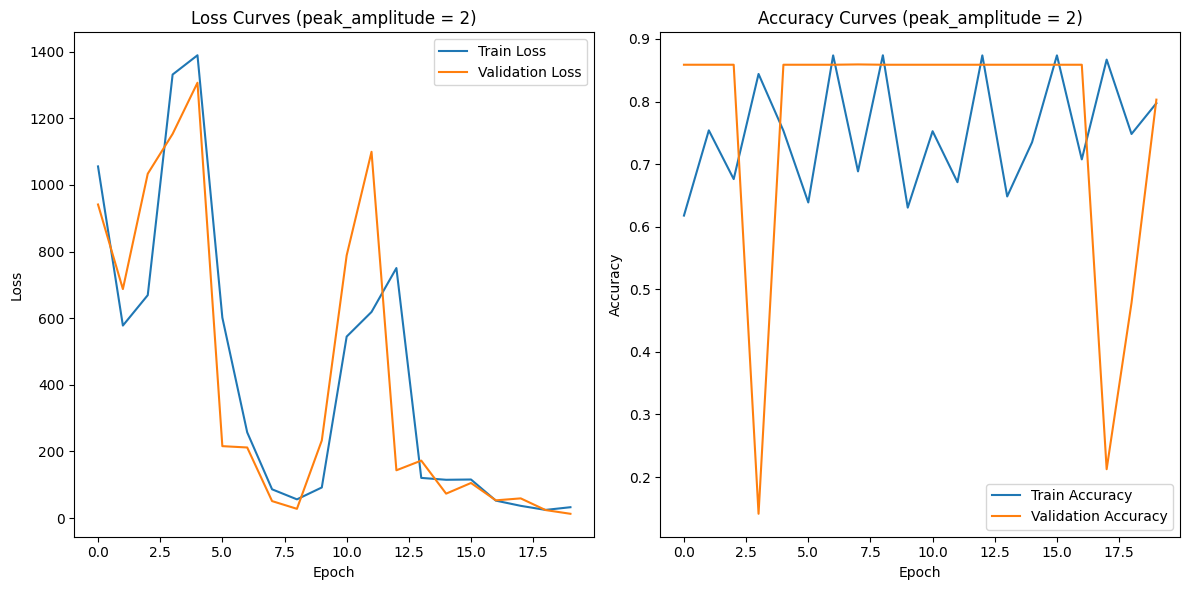

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Track losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop with validation
for epoch in range(20):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for sequences, labels in train_dataloader:
        sequences, labels = sequences.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, _ = model(sequences, attn_mask=None)

        # Compute loss
        loss = criterion(outputs.view(-1, num_classes), labels.view(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Compute training accuracy
        preds = outputs.argmax(dim=-1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.numel()

    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for sequences, labels in val_dataloader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs, _ = model(sequences, attn_mask=None)

            # Compute loss
            loss = criterion(outputs.view(-1, num_classes), labels.view(-1))
            val_loss += loss.item()

            # Compute validation accuracy
            preds = outputs.argmax(dim=-1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.numel()

    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}, Train Loss: {train_loss}, Train Acc: {train_accuracy}, Val Loss: {val_loss}, Val Acc: {val_accuracy}")

# Plot learning curves (loss and accuracy)
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss Curves (peak_amplitude = {peak_amplitude})')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy Curves (peak_amplitude = {peak_amplitude})')
plt.legend()

plt.tight_layout()
plt.show()


In [45]:
# Construct the test dataset
test_data = construct_dataset(num_signals=50, signal_length=signal_length, chunk_size=chunk_size, peak_amplitude=peak_amplitude)
test_dataset = TimeSeriesDataset(test_data, chunk_size, sequence_length)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for sequences, labels in test_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        outputs, _ = model(sequences, attn_mask=None)
        preds = outputs.argmax(dim=-1).cpu().numpy()
        all_preds.extend(preds.flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

# Classification report
print(classification_report(all_labels, all_preds, target_names=['Normal', 'Abnormal']))

              precision    recall  f1-score   support

      Normal       0.88      0.87      0.87      8755
    Abnormal       0.13      0.15      0.14      1245

    accuracy                           0.78     10000
   macro avg       0.51      0.51      0.51     10000
weighted avg       0.78      0.78      0.78     10000



In [46]:
# print the accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7768


In [47]:
num_matches = sum(p == l for p, l in zip(all_preds, all_labels))

print(f"Number of matches: {num_matches}")

Number of matches: 7768


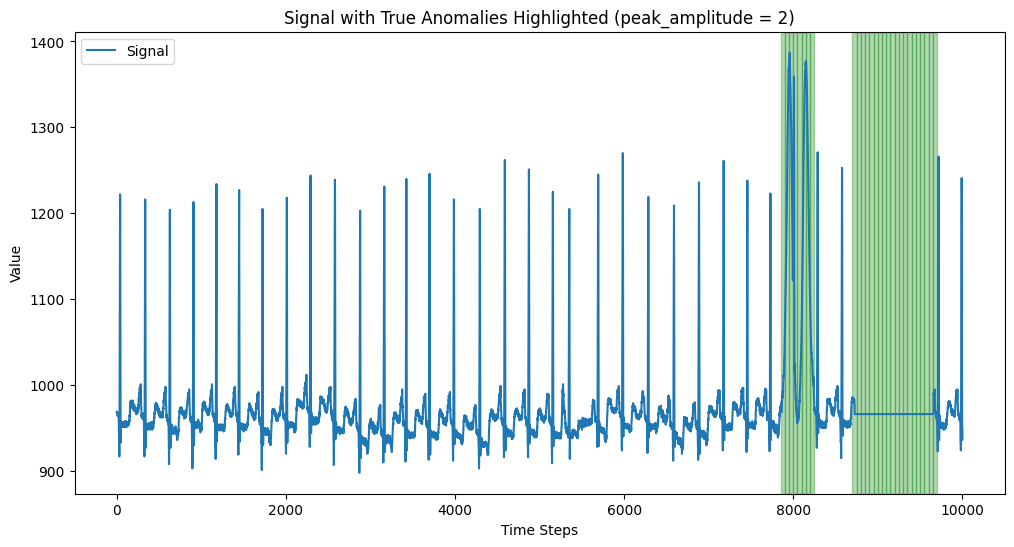

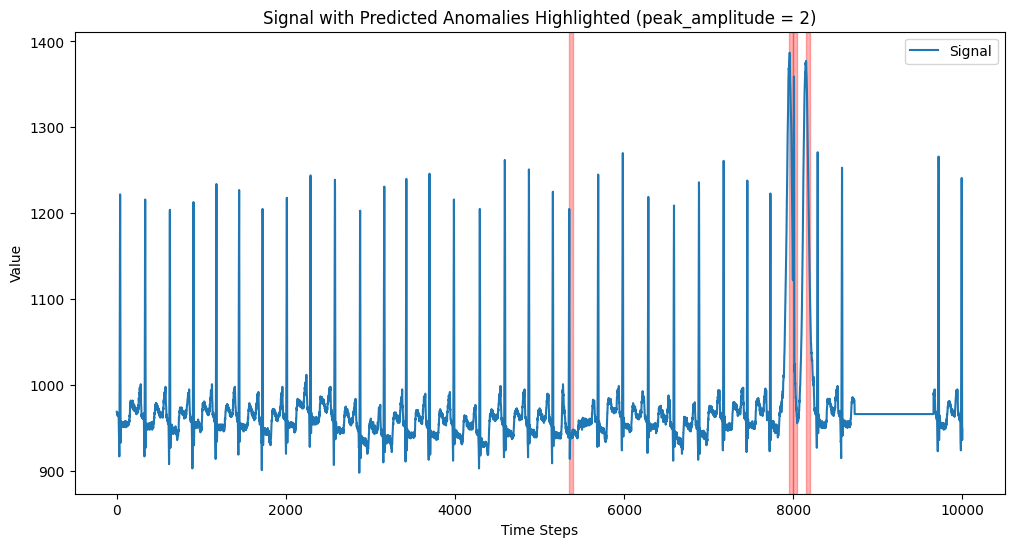

In [49]:
# Extract and preprocess data
sequence, label = test_dataset[1]
sequence, label = sequence.to(device), label.to(device)
sequence = sequence.unsqueeze(0)  # Add batch dimension if missing

# Make predictions
outputs, attn_weights = model(sequence, attn_mask=None)
predicted_labels = outputs.argmax(dim=-1).cpu().numpy().flatten()

# Plot 1: Signal with true anomalies
plt.figure(figsize=(12, 6))
plt.plot(sequence.squeeze(0).cpu().numpy().flatten(), label='Signal')
plt.xlabel('Time Steps')
plt.ylabel('Value')
for i, lbl in enumerate(label):
    if lbl == 1:  # True abnormal
        start = i * chunk_size
        end = start + chunk_size
        plt.axvspan(start, end, color='green', alpha=0.3, label="True Anomaly" if i == 0 else "")
plt.title(f"Signal with True Anomalies Highlighted (peak_amplitude = {peak_amplitude})")
plt.legend()
plt.show()

# Plot 2: Signal with predicted anomalies
plt.figure(figsize=(12, 6))
plt.plot(sequence.squeeze(0).cpu().numpy().flatten(), label='Signal')
plt.xlabel('Time Steps')
plt.ylabel('Value')
for i, lbl in enumerate(predicted_labels):
    if lbl == 1:  # Predicted abnormal
        start = i * chunk_size
        end = start + chunk_size
        plt.axvspan(start, end, color='red', alpha=0.3, label="Predicted Anomaly" if i == 0 else "")
plt.title(f"Signal with Predicted Anomalies Highlighted (peak_amplitude = {peak_amplitude})")
plt.legend()
plt.show()

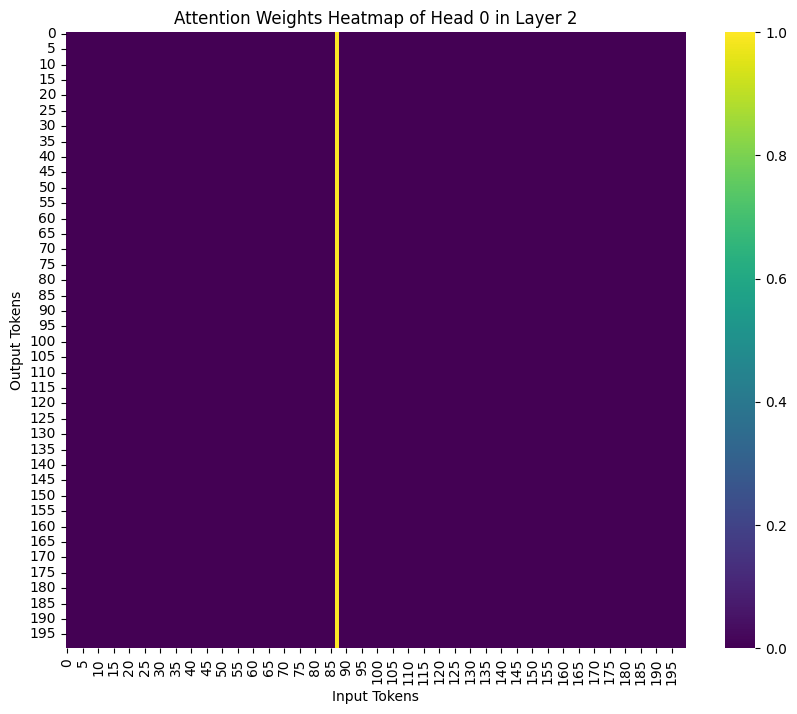

In [70]:
# Visualize the first attention head of the last layer
attn_weights = attn_weights.squeeze(0)  # Remove batch dimension
which_layer = 2
which_head = 0
attn_head = attn_weights[which_layer][which_head] # first choose layer, then choose head
plt.figure(figsize=(10, 8))
sns.heatmap(attn_head.detach().cpu().numpy(), cmap='viridis')
plt.title(f'Attention Weights Heatmap of Head {which_head} in Layer {which_layer}')
plt.xlabel('Input Tokens')
plt.ylabel('Output Tokens')
plt.show()

In [64]:
attn_weights.shape

torch.Size([6, 4, 200, 200])